# HomeWork1 - exercise 3

In [71]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io 
import scipy
import cvxpy as cp
%matplotlib inline

np.set_printoptions(precision=2, suppress= True)
#----------------------------------------------
file = scipy.io.loadmat('capacities.mat')
c = file.get('capacities')
c = c.reshape(28,)
#----------------------------------------------
file = scipy.io.loadmat('traveltime.mat')
l = file.get('traveltime')
l = l.reshape(28,)
#----------------------------------------------
file = scipy.io.loadmat('traffic.mat')
B = file.get('traffic')

In [73]:
import matplotlib.pyplot as plt
import networkx as nx

# === direct graph creation ===
G = nx.DiGraph()

for edge in range(n_edges):
    capac = c[edge]
    travtime = l[edge]
    for node in range(n_nodes):
        if B[node][edge] == 1: #tail (source)
            i = node
        if B[node][edge] == -1: #head (destination)
            j = node
    G.add_edges_from([(i+1, j+1)], capacity=capac, traveltime=travtime)

# === Node positions (as before) ===
pos = {
    1: [-4, 3], 2: [-2, 2.5], 3: [0, 2.5], 4: [2.5, 2.2], 5: [4, 1.5],
    6: [-3.5, 1], 7: [-2, 0.8], 8: [0, 0.5], 9: [2, 0.3],
    10: [-4, -1.5], 11: [-2, -1.7], 12: [0, -2], 13: [2, -2.2], 14: [4, -2.5],
    15: [-2.5, -3.5], 16: [0, -3.8], 17: [2.5, -3.6],
}

nodes = list(G.nodes())             # [1, 2, 3, ..., n]
edges = list(G.edges())             # ordering used for both B and f

#B = np.zeros((n_nodes, n_edges))
#for e_idx, (u, v) in enumerate(edges):
 #   # +1 at tail (source of the directed edge)
#    B[nodes.index(u), e_idx] = 1
    # -1 at head (destination)
#    B[nodes.index(v), e_idx] = -1


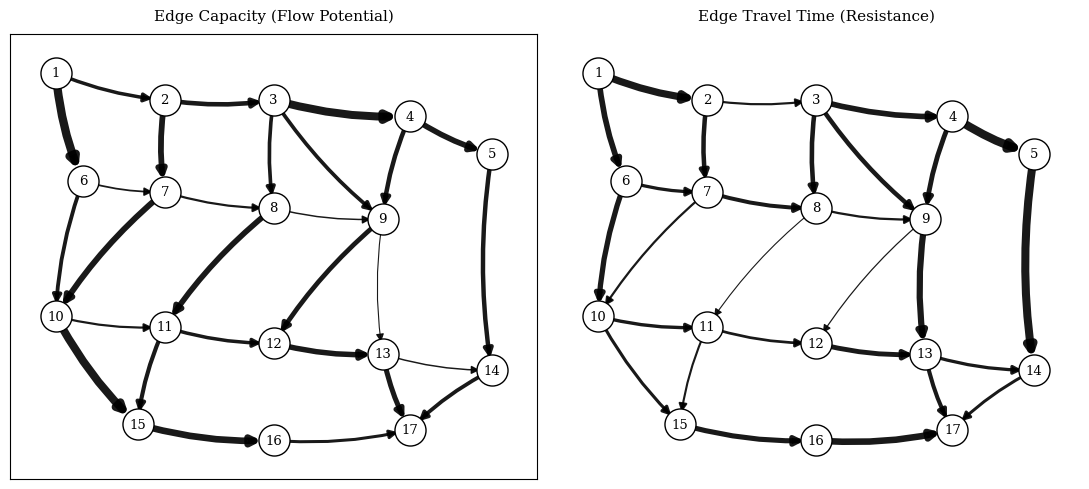

In [74]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, attr, title in zip(
    axes,
    ['capacity', 'traveltime'],
    ['Edge Capacity (Flow Potential)', 'Edge Travel Time (Resistance)']
):
    ax.set_facecolor("white")
    plt.axis("off")

    # === Scale edge widths proportionally ===
    values = np.array([G[u][v][attr] for u, v in G.edges()])
    min_w, max_w = 0.8, 6
    if values.ptp() == 0:
        widths = np.full_like(values, (min_w + max_w) / 2)
    else:
        widths = min_w + (values - values.min()) * (max_w - min_w) / values.ptp()

    # === Draw network ===
    nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color="black",
        arrows=True,
        arrowsize=12,
        connectionstyle="arc3,rad=0.08",
        alpha=0.9,
        ax=ax
    )
    nx.draw_networkx_nodes(
        G, pos,
        node_color="white",
        edgecolors="black",
        linewidths=1,
        node_size=500,
        ax=ax
    )
    nx.draw_networkx_labels(
        G, pos,
        font_size=9.5,
        font_family="serif",
        font_weight="light",
        ax=ax
    )

    ax.set_title(title, fontsize=11, fontfamily="serif", pad=10)

plt.tight_layout()
plt.savefig("plot3_capacity_vs_traveltime.svg", bbox_inches='tight', dpi=300)
plt.show()

In [75]:
edge_list = list(G.edges())
edge_list

[(1, 2),
 (1, 6),
 (2, 3),
 (2, 7),
 (3, 4),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 9),
 (5, 14),
 (6, 7),
 (6, 10),
 (7, 8),
 (7, 10),
 (8, 9),
 (8, 11),
 (9, 13),
 (9, 12),
 (13, 14),
 (13, 17),
 (14, 17),
 (10, 11),
 (10, 15),
 (11, 12),
 (11, 15),
 (15, 16),
 (12, 13),
 (16, 17)]

## **A)** Find the shortest path between node **1** and **17**. This is equivalent to the **fastest path** (path with shortest traveling time) in an empty network.

In [76]:
source = 1
sink = 17

### **LP**

In [77]:
𝜏 = 1 #tau

ν = np.zeros(n_nodes)
ν[source-1] = 𝜏
ν[sink-1] = -𝜏

f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == ν, f >=0]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print("Optimal f:", f.value)

Optimal f: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]


In [78]:
print(f'ν check : {B @ f.value}') 

ν check : [ 1. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -1.]


In [79]:
used_edges_idx = np.where(f.value > 1e-6)[0]  # tolerance to ignore tiny numerical noise

# let's reconstruct directed edges from B
path_edges = []
for e_idx in used_edges_idx:
    u = np.where(B[:, e_idx] == 1)[0][0]   # tail node index
    v = np.where(B[:, e_idx] == -1)[0][0]  # head node index
    path_edges.append((u + 1, v + 1))      # +1 to match node labels in G (1-indexed)


print("The path retrieved from LP flow:", path_edges)

The path retrieved from LP flow: [(1, 2), (2, 3), (9, 13), (3, 9), (13, 17)]


### **Dijkstra** confirm

The shortest path from node 1 to node 17: [1, 2, 3, 9, 13, 17]


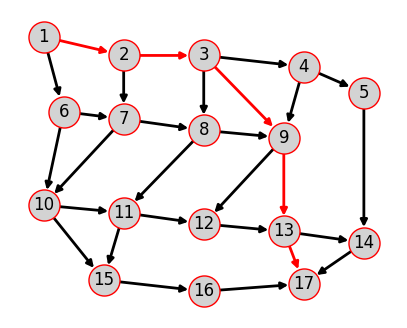

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

# Compute the shortest path
shortest_path = nx.shortest_path(G, source=1, target=17, weight='traveltime')
print("The shortest path from node 1 to node 17:", shortest_path)


edge_colors = []
for u, v in G.edges():
    in_path = any(u == shortest_path[i] and v == shortest_path[i+1] for i in range(len(shortest_path)-1))
    edge_colors.append('red' if in_path else 'black')

# Draw the graph
fig, ax = plt.subplots(figsize=(5,4))
nx.draw(G, pos, node_size=500, font_size=12, node_color='lightgray', with_labels=True,
        width=2, edge_color=edge_colors, edgecolors='red', ax=ax)

plt.savefig("plot3.2.svg")
plt.show()

## **B)** Find the maximum flow between node **1** and **17**.

In [81]:
flow_value, flow_dict = nx.maximum_flow(G, source, sink)

print(f"Maximum flow from node 1 to node 17: {flow_value}\n")
print("Flow along each edge:")
for u, flows in flow_dict.items():
    for v, f in flows.items():
        if f > 0:  # only show edges with positive flow
            print(f"  {u} -> {v}: {f}")

Maximum flow from node 1 to node 17: 22448

Flow along each edge:
  1 -> 2: 8741
  1 -> 6: 13707
  2 -> 3: 8741
  3 -> 9: 8741
  6 -> 7: 4624
  6 -> 10: 9083
  7 -> 8: 4624
  8 -> 9: 4624
  9 -> 13: 6297
  9 -> 12: 7068
  13 -> 14: 3835
  13 -> 17: 10355
  14 -> 17: 3835
  10 -> 11: 825
  10 -> 15: 8258
  11 -> 12: 825
  15 -> 16: 8258
  12 -> 13: 7893
  16 -> 17: 8258


## **C)** Given the flow vector in *flow.mat*, compute the external inflow $v$ satisfying $Bf = v$

In [82]:
file = scipy.io.loadmat('flow.mat')
f = file.get('flow')
f = f.reshape(28,)

external_inflow = B @ f
external_inflow

array([ 16806,   8570,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

## **D)** Find the social optimum $f^*$ with respect to the delays on the different links $f _{e}d _{e}$, for this minimize cost function
## $\sum_{e \in \varepsilon}f _{e}\tau_{e}(f_{e}) = \sum_{e \in \varepsilon}^{} \left ( \frac{f _{e}l _{e} }{ 1 - f _{e}/c _{e} } - l _{e}c _{e}  \right ) $

In [83]:
# exogenous inflow vector
ν1 = external_inflow[0]
nu = np.array([ν1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, -ν1]) 

f = cp.Variable(n_edges)

#cost function 
func = cp.multiply(l*c, cp.inv_pos(1 - cp.multiply(f,1/c))) - l*c  #inv_pos --> ensure convexity (avoid dividing by 0)                      
func = cp.sum(func)

# Construct the problem.
# Minimize cost function
objective = cp.Minimize(func)
constraints = [B @ f == nu, f >=0, f <= c]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [ 6569.34  5810.01  3046.97  3046.97 10236.66  4666.34  3061.21  2595.99
  3104.56   759.33     0.01  2763.03     0.    3046.97  5570.32  2893.84
  5040.94  2364.46   465.23  2254.46  3359.07  5613.53  2371.99     0.
  6346.1   5418.96  5040.94  5040.94]
Optimal cost: 26142.669749995475


In [84]:
n_nodes, n_links = B.shape
eps = 1e-6  # small slack to keep f < c strictly

def tau(f):
    # τ_e(f) = l_e / (1 - f_e / c_e)
    return l / (1 - f / c)

def tau_prime(f):
    # τ'_e(f) = l_e / [ c_e (1 - f_e/c_e)^2 ]
    return l / (c * (1 - f / c)**2)


## **E)** Find the Wardrop equilibrium $f^{(0)}$ by solving
$$
f^{(0)} = \arg\min_{f \in \mathcal{F}} \sum_{e \in \mathcal{E}} \int_{0}^{f_e} \tau_e(s)\, ds.
$$


Let's solve the integral before put him in the objective function. We have : 
$$
f^{(0)} = \sum_e \int_0^{f_e} \tau_e(s)\,ds
\qquad\text{with}\qquad
\tau_e(s) = \frac{\ell_e}{1 - \frac{s}{c_e}}.
$$

Then
$$
\int_0^{f_e} \frac{\ell_e}{1 - \frac{s}{c_e}}\,ds
= \ell_e c_e \int_0^{f_e} \frac{1}{c_e - s}\,ds
= \ell_e c_e \left[ -\ln(c_e - s) \right]_0^{f_e}.
$$

Thus
$$
= \ell_e c_e \big(\ln(c_e) - \ln(c_e - f_e)\big)
= -\,\ell_e c_e \ln\!\left(1 - \frac{f_e}{c_e}\right),
$$

and therefore
$$
\boxed{
f^{(0)} = \sum_e -\,\ell_e c_e \ln\!\left(1 - \frac{f_e}{c_e}\right)
}
$$


Here we compute the Wardrop (user equilibrium) flow.  
This represents the situation where no driver can reduce their travel time by changing routes.  
It is obtained by minimizing the Beckmann potential using the link travel time functions.


In [85]:
n_nodes, n_links = B.shape
eps = 1e-6

# variable
f = cp.Variable(n_links)

# Beckmann potential: sum_e - l_e * c_e * log(1 - f / c_e)
integral = - cp.multiply(l * c, cp.log( 1 - (cp.multiply(f, 1/c) )))
func2 = cp.sum(integral)
obj_e = cp.Minimize(func2)


# constraints---------------------------
cons_e = [
    B @ f == nu,
    f >= 0,
    f <= c - eps
]#--------------------------------------


# solve (ECOS first, then SCS fallback)
prob_e = cp.Problem(obj_e, cons_e)

    # The optimal objective value is returned by `prob.solve()`.
result_w = prob_e.solve()
    # The optimal value for f is stored in `f.value`.
print("The flow at Wardrop equilibrium is:")
print(f.value)
print('')


The flow at Wardrop equilibrium is:
[ 6557.56  6308.63  2200.63  2200.63 10248.44  4706.68  2859.9   2232.66
  3350.04   248.93    11.67  4096.33     0.    2200.63  5541.76  2343.34
  5294.13  2095.72   638.91  2978.94  2982.25  5961.2   2522.45     0.
  6788.79  4723.08  5294.13  5294.13]



Compute the cost of wardrop equilibrium with: $\sum_{e \in \varepsilon}^{} f _{e} d _{e}(f _{e}) $ and Price of Anarchy $$PoA(0) = \frac {cost_{Wardrop}}{cost_{social optimum}}$$

In [86]:
# cost, defined as \sum_e f_e d_e(f_e)
def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((l[i]*c[i]) / (1-(value/c[i])))-l[i]*c[i])
    return sum(tot)

cost_w = cost(f.value) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)  

Wardrop cost: 26495.33292385524
The price of anarchy: 1.0134899448767976


## **F)** Introduce tolls such that the toll on link $e$ is

$$
\omega_e = \psi_e'(f_e^*) - \tau_e(f_e^*),
$$

where $f_e^*$ is the flow at the **system optimum**.  

For the considered $\psi_e(f_e)$, this simplifies to

$$
\omega_e = f_e^* \, \tau_e'(f_e^*).
$$

It represents the additional total delay that all other drivers experience if one extra driver uses edge $e$.

-	$\tau_e'(f_e^*)$ measures how much the travel time increases if one more car enters the link.
-	Multiplying by $f_e^*$ gives the extra congestion cost imposed on all other drivers, which is exactly the toll $\omega_e^*$.


Then, the **effective delay** on link $e$ becomes

$$
\tau_e(f_e) + \omega_e.
$$



The **new Wardrop equilibrium** $f(\omega)$ is computed by minimizing the total travel cost with these tolls:

$$
f(\omega) = \arg\min_f \sum_e \int_0^{f_e} \big(\tau_e(s) + \omega_e\big)\, ds,
\quad \text{s.t. flow conservation constraints.}
$$

**Observation:** At this new equilibrium $f(\omega)$, the selfish route choices of users **coincide with the system-optimal flows**, i.e.,

$$
f(\omega) = f^*.
$$

In [87]:
f = cp.Variable(n_edges)

#compute omega
omega = []
for i, value in enumerate(opt_flow):
    omega.append(value*((c[i]*l[i])/((c[i]-value)**2)))

func3 = cp.sum(cp.multiply(omega, f) - cp.multiply(c*l, cp.log(1-(cp.multiply(f, 1/c)))))

objective = cp.Minimize(func3)
constraints = [B @ f == nu, f >=0, f <= c]
prob = cp.Problem(objective, constraints)

result = prob.solve()

print("Wardrop equilibrium with tolls:", f.value)

Wardrop equilibrium with tolls: [ 6568.21  5810.04  3047.2   3047.2  10237.79  4667.46  3061.09  2595.99
  3104.38   758.17     0.    2762.84     0.    3047.2   5570.34  2893.9
  5040.96  2364.53   465.1   2254.46  3359.    5613.46  2371.79     0.
  6346.05  5418.98  5040.96  5040.96]


In [88]:
war_vect = f.value
#compute cost of wardrop equilibrium
cost_w = cost(war_vect) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA) 

Wardrop cost: 26142.671104956044
The price of anarchy: 1.0000000518294643


## **G)** Instead of the total delay, let the cost be the total additional delay compared to the total delay in free flow be given by  $c _{e}f _{e} = f _{e}( d _{e}(f _{e}) - l _{e} )$  subject to the flow constraints. Compute the system optimum $f^*$ for the costs given.

Here we minimize the total additional travel time compared to free-flow conditions.  
We then compute the corresponding tolls that make the Wardrop equilibrium reproduce this system-optimal flow.  
Finally, we verify that the tolled equilibrium gives the same result as the additional-time optimum.


In [89]:
f = cp.Variable(n_edges)

#cost function free flow delay
func4 = cp.sum(cp.multiply( cp.multiply(l, c), cp.inv_pos(1 - cp.multiply(f, 1/c) ) ) - cp.multiply(l, c) - cp.multiply(l,f) )

objective = cp.Minimize(func4)
constraints = [B @ f == nu, f >=0, f <= c]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [ 6584.51  5577.71  3367.56  3367.56 10221.49  4669.44  3156.52  2711.95
  2987.89  1006.8      0.    2210.14     0.01  3367.56  5552.05  3084.85
  4986.92  2519.73   444.57  1934.2   3529.42  5463.63  2202.21     0.
  6249.31  5569.77  4986.92  4986.92]
Optimal cost: 15350.354156595688


Construct tolls $\omega^* _{e}$ such that the new Wardrop equilibrium with the constructed tolls $f^{(\omega^*)}$ coincides with $f^{*}$

In [90]:
w = cp.Variable(n_edges)
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

# cost function with optimal flow
integral = - cp.multiply(c*l, cp.log(1-(cp.multiply(opt_flow, 1/c)))) - cp.multiply(opt_flow,l) + cp.multiply(w, opt_flow)
func5 = cp.sum(integral)

objective = cp.Minimize(func5)
constraints = [B @ w == nu, w>=0]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Constructed tolls:", w.value)

constr_tolls = w.value

Constructed tolls: [16806.     0.     0.     0.     0.     0. 16806.     0.     0. 16806.
     0.     0.     0.     0.     0.     0.     0.     0. 16806.     0.
     0.     0.     0. 16806.     0.     0. 16806. 16806.]


Compute the new Wardrop equilibrium with the constructed tolls $f^{(\omega^*)}$ to verify your result.

In [91]:
f = cp.Variable(n_edges)
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

func = - cp.multiply(c*l, cp.log(1-(cp.multiply(f, 1/c)))) - cp.multiply(f,l) + cp.multiply(constr_tolls, f)

objective = cp.Minimize(cp.sum(func))
constraints = [B @ f == nu, f >=0, f <= c, f==opt_flow]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Wardrop equilibrium:", f.value)

Wardrop equilibrium: [ 6584.51  5577.71  3367.56  3367.56 10221.49  4669.44  3156.52  2711.95
  2987.89  1006.8      0.    2210.14     0.01  3367.56  5552.05  3084.85
  4986.92  2519.73   444.57  1934.2   3529.42  5463.63  2202.21     0.
  6249.31  5569.77  4986.92  4986.92]


In [92]:
def cost2(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((l[i]*c[i]) / (1-(value/c[i])))-l[i]*c[i]-l[i]*value)
    return sum(tot)

war_vect = f.value
cost_w = cost2(war_vect) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA) 

Wardrop cost: 15350.353489569265
The price of anarchy: 0.9999999565465125


Compute the cost of wardrop equilibrium with: $\sum_{e \in \varepsilon}^{} f _{e} d _{e}(f _{e}) $ and Price of Anarchy $PoA(0) = \frac {wardrop cost}{social optimum cost}$